# Loading data set

In [1]:
import pandas as pd
df = pd.read_csv('xor.csv')
df

,x1,x2,class label
0,0.781306,1.062984,0
1,-1.060524,-1.095550,0
2,0.632125,0.674028,0
3,-1.424712,0.535203,1
4,1.383161,1.368510,0
...,...,...,...
745,0.792484,0.839275,0
746,0.582466,-0.749250,1
747,-1.593475,0.671721,1
748,-0.812671,-0.268542,0


# Prepare train, validation, test data

In [14]:
X = df[["x1", "x2"]].values
y = df["class label"].values

In [15]:
from sklearn.model_selection import train_test_split

# random_state provides a random see for random method, so every time we will get same result
# stratify means make the binary classification size output ratio in the data set is nearlly equal
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.15, random_state = 1, shuffle = True, stratify = y)

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size = 0.1, random_state = 1, shuffle = True, stratify = y)

In [16]:
# split X_train, y_train to train and validation set
X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.1, random_state=1, stratify=y_train)

In [18]:
import numpy as np

print("Training labels:", np.bincount(y_train))
print("Validation labels:", np.bincount(y_val))
print("Testing labels:", np.bincount(y_test))

Training labels: [287 286]
Validation labels: [32 32]
Testing labels: [57 56]


# Visualization the data

In [19]:
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 300


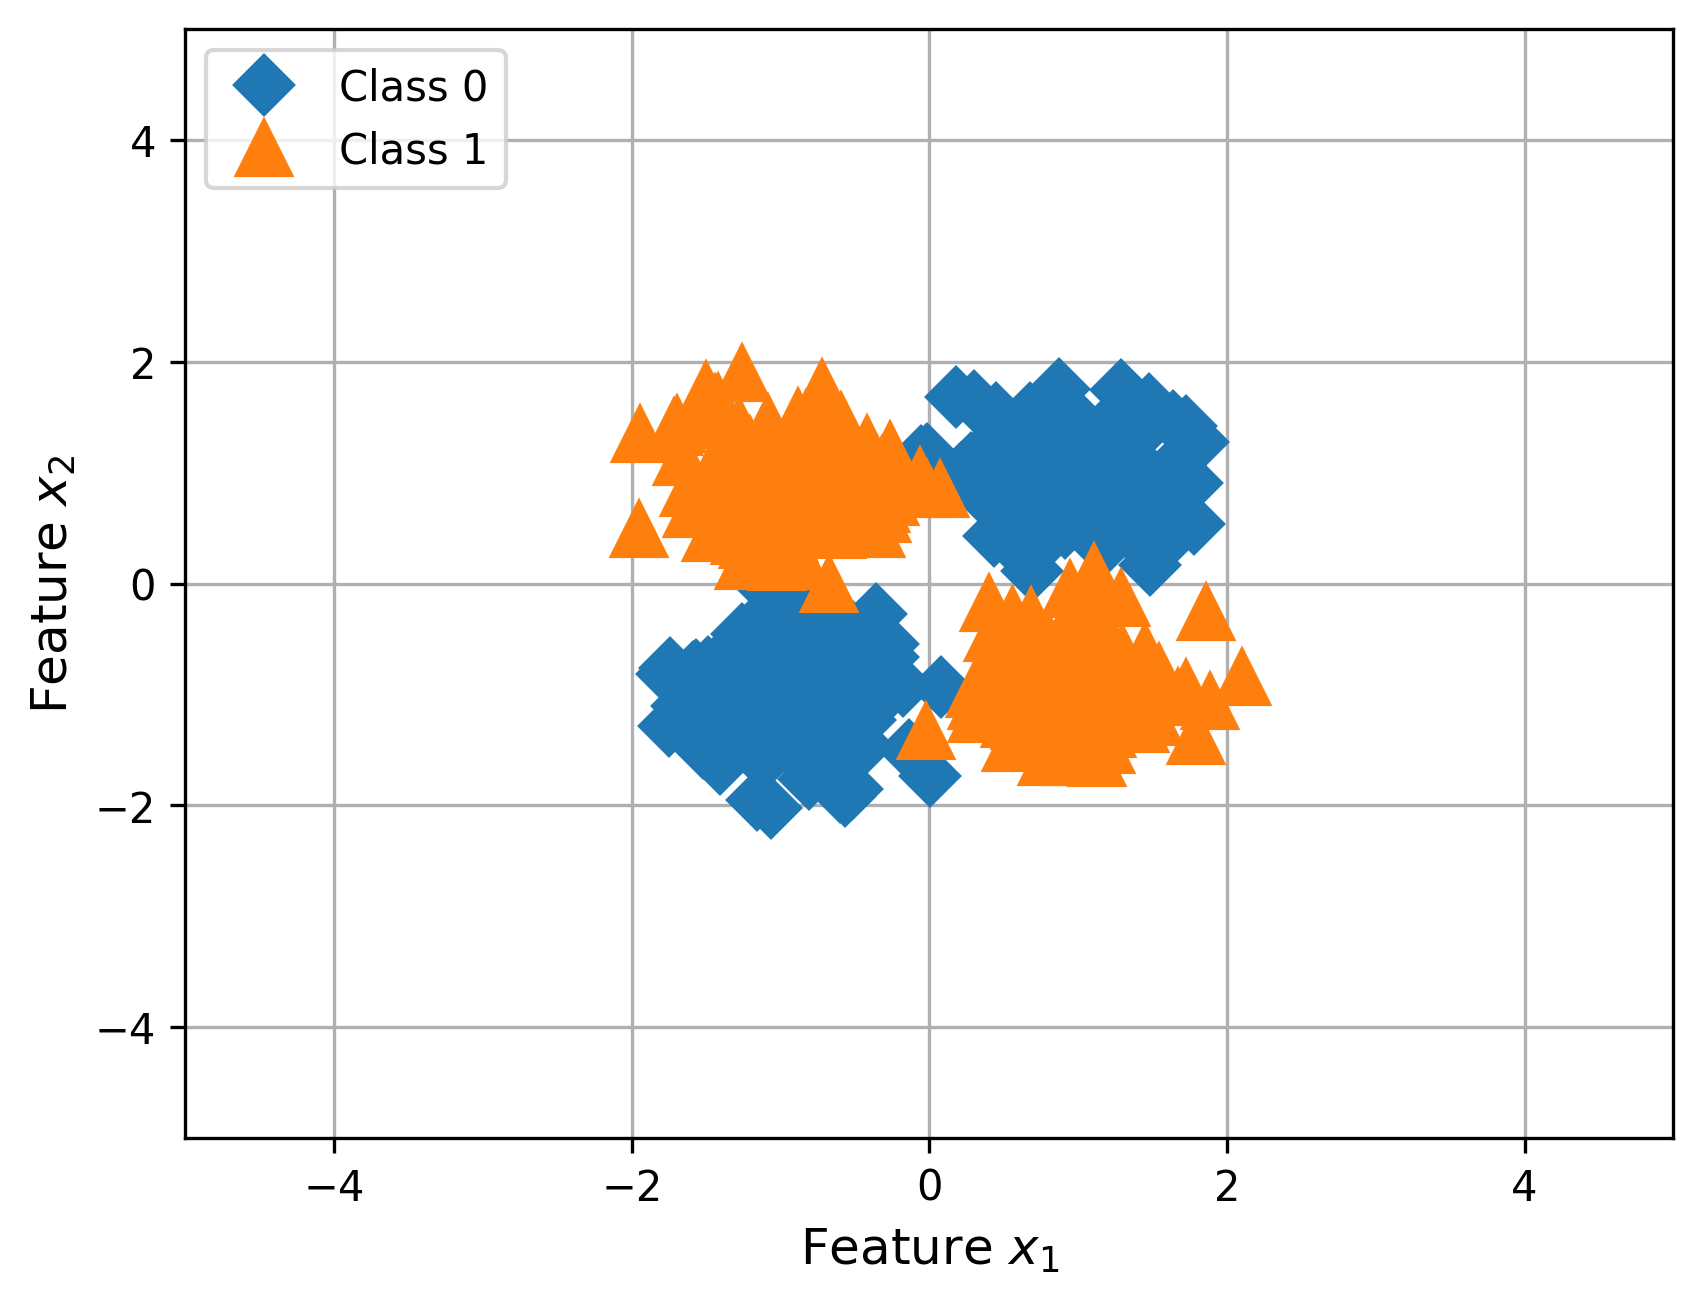

In [20]:
plt.plot(
    X_train[y_train == 0, 0],
    X_train[y_train == 0, 1],
    marker="D",
    markersize=10,
    linestyle="",
    label="Class 0",
)

plt.plot(
    X_train[y_train == 1, 0],
    X_train[y_train == 1, 1],
    marker="^",
    markersize=13,
    linestyle="",
    label="Class 1",
)

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)

plt.grid()
plt.show()

# Implement the model

In [32]:
import torch

class PyTorchMLP(torch.nn.Module):
    #num_features=2, num_classes=2
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # first layer
            torch.nn.Linear(num_features, 25),
            #activation function
            torch.nn.ReLU() ,

            #second layer
            torch.nn.Linear(25, 15),
            torch.nn.ReLU(),

            torch.nn.Linear(15, num_classes)
        )

    def forward(self, x):
        logits = self.all_layers(x)
        return logits

# Define a dataloader

In [24]:
from torch.utils.data import Dataset, DataLoader

In [25]:
class MyDataset(Dataset):
    def __init__(self, X, y):

        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]        
        return x, y

    def __len__(self):
        return self.labels.shape[0]
    

train_ds = MyDataset(X_train, y_train)
val_ds = MyDataset(X_val, y_val)
test_ds = MyDataset(X_test, y_test)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_ds,
    batch_size=32,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=32,
    shuffle=False,
)


# Defining Training Loop

In [38]:
def compute_accuracy(model, dataloader):
    model = model.eval() # model goes to evaluation mode

    correct = 0.0
    total_examples = 0.0
    
    for idx, (features, labels) in enumerate(dataloader):
        with torch.inference_mode(): # same as torch.no_grad()
            logits = model(features)

        # 为什么可以直接用argmax计算predication, 而不需要softmax
        # 这个是因为，如果logits[i] > logits[j], softmax(logits[i]) > softmax(logits[j])
        # 也就是说softmax并不会改变logits的大小关系， 所以argmax可以直接应用的logits，而不需要先call softmax
        predictions = torch.argmax(logits, dim = 1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

##Training loop##

- Similar to Unit 3.6 -- Logistic Regression in PyTorch
- Differences are
  - PytorchMLP instead of LogisticRegression model
  - F.cross_entropy instead of F.binary_cross_entropy

- Note that F.cross_entropy takes logits as inputs, not probabilities
  - it does the one-hot encoding and softmax internally

In [37]:
import torch.nn.functional as F


torch.manual_seed(1)
model = PyTorchMLP(num_features=2, num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) # Stochastic gradient descent

num_epochs = 10

for epoch in range(num_epochs):
    
    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)

        # cross_entropy 
        #    - 会apply softmax to logits
        #    - 会对label进行one hot spot encoding
        # 然后内部会找到one hot spot为1的index，apply l += -log(probs[index])
        # 所以model 最后layer不需要手动写softmax
        loss = F.cross_entropy(logits, labels) # Loss function
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        ### LOGGING
        print(f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
              f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
              f" | Train/Val Loss: {loss:.2f}")
    
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")

tensor([[0.0819, 0.1149],
        [0.0743, 0.1401],
        [0.0669, 0.1583],
        [0.0773, 0.1187],
        [0.0989, 0.0614],
        [0.0509, 0.2046],
        [0.0662, 0.1615],
        [0.0678, 0.0655],
        [0.0901, 0.1433],
        [0.0691, 0.1247],
        [0.0451, 0.1985],
        [0.0529, 0.2058],
        [0.0782, 0.1640],
        [0.0709, 0.1231],
        [0.0803, 0.1605],
        [0.0533, 0.0927],
        [0.0958, 0.0601],
        [0.0512, 0.2385],
        [0.0658, 0.0203],
        [0.0405, 0.2262],
        [0.0560, 0.2293],
        [0.0768, 0.1414],
        [0.0718, 0.1519],
        [0.0420, 0.2295],
        [0.0868, 0.0349],
        [0.0386, 0.2307],
        [0.0390, 0.2648],
        [0.0700, 0.1523],
        [0.0735, 0.1484],
        [0.0768, 0.0734],
        [0.0649, 0.1321],
        [0.1084, 0.0809]])
tensor([[0.0960, 0.0342],
        [0.0746, 0.0432],
        [0.0525, 0.0421],
        [0.0663, 0.1833],
        [0.0630, 0.1681],
        [0.0306, 0.2581],
        [0.